In [1]:
#imports
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import nltk
from transformers import Trainer, TrainingArguments
import torch
import logging
import random
import warnings
warnings.filterwarnings("ignore")

C:\Users\aqibs\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Had to reduce the dataset to train the model as kernel was failing because of low compute

In [2]:
df = pd.read_csv(r"C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv", encoding='utf-8')

In [3]:
#drop null values
df.dropna(inplace=True)

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aqibs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)    # remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove non-alphabetic characters
    text = text.lower()  # convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

df['news'] = df['news'].apply(preprocess_text)

In [6]:
#converting all the labels to lower case
df['label'] = df['label'].apply(lambda x: x.lower())
unique_labels = df['label'].unique()
print(unique_labels)
df.dropna(inplace=True)

['positive' 'negative' 'neutral']


In [7]:
# Map labels to integers
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
df['label'] = df['label'].map(label_mapping)
unique_labels = df['label'].unique()
print(unique_labels)

[0 1 2]


In [8]:
# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['news'], df['label'], test_size=0.2, random_state=42)

In [9]:
print(len(train_texts), len(train_labels))
print(len(test_texts), len(test_labels))

1600 1600
400 400


In [10]:
# Load tokenizer and model
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [11]:
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors='pt')

train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(test_texts.tolist())

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Print shapes and lengths to verify alignment
print("Train encodings shape:", train_encodings['input_ids'].shape)
print("Train labels length:", len(train_labels))
print("Test encodings shape:", test_encodings['input_ids'].shape)
print("Test labels length:", len(test_labels))

Train encodings shape: torch.Size([1600, 512])
Train labels length: 1600
Test encodings shape: torch.Size([400, 512])
Test labels length: 400


In [12]:
print("Train labels sample:", train_labels[:10])  
print("Test labels sample:", test_labels[:10])

Train labels sample: tensor([2, 0, 2, 2, 0, 0, 2, 0, 2, 2])
Test labels sample: tensor([1, 0, 2, 0, 2, 2, 2, 1, 1, 1])


In [13]:
#custom Dataset class inheriting from PyTorch's Dataset class.
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):# Store the encodings and labels as class attributes.
        self.encodings = encodings
        self.labels = labels

    # Retrieve a single sample from the dataset at the specified index
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]  # Use the label directly
        return item

    # Return the total number of samples in the dataset.
    def __len__(self):
        return len(self.labels)


train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

In [14]:
print("Train labels shape in dataset:", train_labels.shape)
print("Test labels shape in dataset:", test_labels.shape)

Train labels shape in dataset: torch.Size([1600])
Test labels shape in dataset: torch.Size([400])


In [15]:
#validating the values in the dataset
def validate_dataset(dataset, num_samples=10):
    num_classes = 3  # Update with your actual number of classes
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))   # Sample a few indices randomly from the dataset.
    for i in indices:
        item = dataset[i]
        labels = item['labels']
        if isinstance(labels, torch.Tensor):
            if torch.any(labels < 0) or torch.any(labels >= num_classes):# Check if any label is outside the valid range [0, num_classes)
                print(f"Invalid label at index {i}: {labels}")
        else:
            print(f"Label at index {i} is not a tensor: {labels}")

# Validate a few samples from the datasets
validate_dataset(train_dataset, num_samples=10)
validate_dataset(test_dataset, num_samples=10)

In [16]:
# Set up logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.step = 0

    def training_step(self, model, inputs):
        outputs = super().training_step(model, inputs)# Perform the standard training step and get the outputs

        # Log loss and other metrics
        if isinstance(outputs, torch.Tensor):
            loss = outputs
        else:
            loss = outputs.get('loss', None)

        # Log the loss if it exists
        if loss is not None:
            logger.info(f"Step {self.step}: Loss = {loss.item()}")
        self.step += 1

        return outputs

    def log(self, logs: dict):
        super().log(logs)
        # Log additional metrics if needed
        logger.info(f"Epoch {self.state.epoch}: {logs}")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=0,
    weight_decay=0.01,  # Weight decay for regularization
    learning_rate=5e-5,  # Learning rate for optimization
    logging_dir='./logs',
    evaluation_strategy='epoch',
    logging_steps=10,
    fp16=True,  # Enable mixed precision training
)

# Initialize Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train and evaluate
trainer.train()
results = trainer.evaluate()
print("Evaluation results:", results)


 10%|█         | 10/100 [02:17<20:08, 13.43s/it]INFO:__main__:Epoch 0.1: {'loss': 1.0764, 'learning_rate': 4.5e-05, 'epoch': 0.1}


{'loss': 1.0764, 'learning_rate': 4.5e-05, 'epoch': 0.1}


INFO:__main__:Step 10: Loss = 1.124481201171875
 20%|██        | 20/100 [04:31<17:45, 13.32s/it]INFO:__main__:Epoch 0.2: {'loss': 1.0802, 'learning_rate': 4.05e-05, 'epoch': 0.2}


{'loss': 1.0802, 'learning_rate': 4.05e-05, 'epoch': 0.2}


INFO:__main__:Step 20: Loss = 1.1170654296875
 30%|███       | 30/100 [06:44<15:37, 13.39s/it]INFO:__main__:Epoch 0.3: {'loss': 1.0011, 'learning_rate': 3.55e-05, 'epoch': 0.3}


{'loss': 1.0011, 'learning_rate': 3.55e-05, 'epoch': 0.3}


INFO:__main__:Step 30: Loss = 0.91680908203125
 40%|████      | 40/100 [08:58<13:25, 13.42s/it]INFO:__main__:Epoch 0.4: {'loss': 0.9457, 'learning_rate': 3.1e-05, 'epoch': 0.4}


{'loss': 0.9457, 'learning_rate': 3.1e-05, 'epoch': 0.4}


INFO:__main__:Step 40: Loss = 0.9049530029296875
 50%|█████     | 50/100 [11:12<11:08, 13.38s/it]INFO:__main__:Epoch 0.5: {'loss': 0.8724, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.5}


{'loss': 0.8724, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.5}


INFO:__main__:Step 50: Loss = 0.8303070068359375
 60%|██████    | 60/100 [13:26<08:53, 13.33s/it]INFO:__main__:Epoch 0.6: {'loss': 0.9158, 'learning_rate': 2.1e-05, 'epoch': 0.6}


{'loss': 0.9158, 'learning_rate': 2.1e-05, 'epoch': 0.6}


INFO:__main__:Step 60: Loss = 0.8796234130859375
 70%|███████   | 70/100 [15:38<06:39, 13.31s/it]INFO:__main__:Epoch 0.7: {'loss': 0.8414, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.7}


{'loss': 0.8414, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.7}


INFO:__main__:Step 70: Loss = 0.90155029296875
 80%|████████  | 80/100 [17:51<04:23, 13.19s/it]INFO:__main__:Epoch 0.8: {'loss': 0.8598, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.8}


{'loss': 0.8598, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.8}


INFO:__main__:Step 80: Loss = 0.7581558227539062
 90%|█████████ | 90/100 [20:03<02:12, 13.29s/it]INFO:__main__:Epoch 0.9: {'loss': 0.8783, 'learning_rate': 6e-06, 'epoch': 0.9}


{'loss': 0.8783, 'learning_rate': 6e-06, 'epoch': 0.9}


INFO:__main__:Step 90: Loss = 0.6775360107421875
100%|██████████| 100/100 [22:16<00:00, 13.29s/it]INFO:__main__:Epoch 1.0: {'loss': 0.8249, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.0}


{'loss': 0.8249, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.0}


                                                 
100%|██████████| 100/100 [23:06<00:00, 13.86s/it]


{'eval_loss': 0.8407092094421387, 'eval_runtime': 49.4062, 'eval_samples_per_second': 8.096, 'eval_steps_per_second': 0.506, 'epoch': 1.0}
{'train_runtime': 1386.1383, 'train_samples_per_second': 1.154, 'train_steps_per_second': 0.072, 'train_loss': 0.9295923233032226, 'epoch': 1.0}


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]

Evaluation results: {'eval_loss': 0.8407092094421387, 'eval_runtime': 49.4122, 'eval_samples_per_second': 8.095, 'eval_steps_per_second': 0.506, 'epoch': 1.0}


In [17]:
# Save the model
model_save_path = './results/my_model'
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer_save_path = './results/my_tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)

('./results/my_tokenizer\\tokenizer_config.json',
 './results/my_tokenizer\\special_tokens_map.json',
 './results/my_tokenizer\\vocab.json',
 './results/my_tokenizer\\merges.txt',
 './results/my_tokenizer\\added_tokens.json')

In [19]:
# Get predictions
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)

# Extract true labels from the dataset
true_labels = np.array([example['labels'] for example in test_dataset])  # Extract labels correctly

# Get unique labels
all_labels = np.unique(true_labels)

# Ensure target names correspond to unique labels
target_names = ['positive', 'negative', 'neutral']  # Adjust based on your label encoding
assert len(all_labels) == len(target_names), "Mismatch between unique labels and target names."

# Print classification report
print(classification_report(true_labels, preds, labels=all_labels, target_names=target_names))


100%|██████████| 25/25 [00:47<00:00,  1.91s/it]

              precision    recall  f1-score   support

    positive       0.58      0.81      0.68       113
    negative       0.55      0.65      0.60       121
     neutral       0.77      0.45      0.57       166

    accuracy                           0.61       400
   macro avg       0.63      0.64      0.61       400
weighted avg       0.65      0.61      0.61       400



Positive Class: The model performs well in terms of recall, identifying 81% of the actual positive instances, but has a moderate precision of 58%, indicating some false positives.

Negative Class: The model has a balanced precision and recall, both around 55-65%, but still has room for improvement.

Neutral Class: The model struggles with neutral instances, with a high precision (77%) but a low recall (45%), suggesting it correctly identifies many of the predicted neutral instances, but misses a significant portion of actual neutral instances.

The model has an accuracy of 61%, indicating that it correctly classifies 61% of the instances. 

* The accuracy of the model would increase if trained more rigorously.
* Due to compute limitations it couldn't handle more epcohs and large dataset

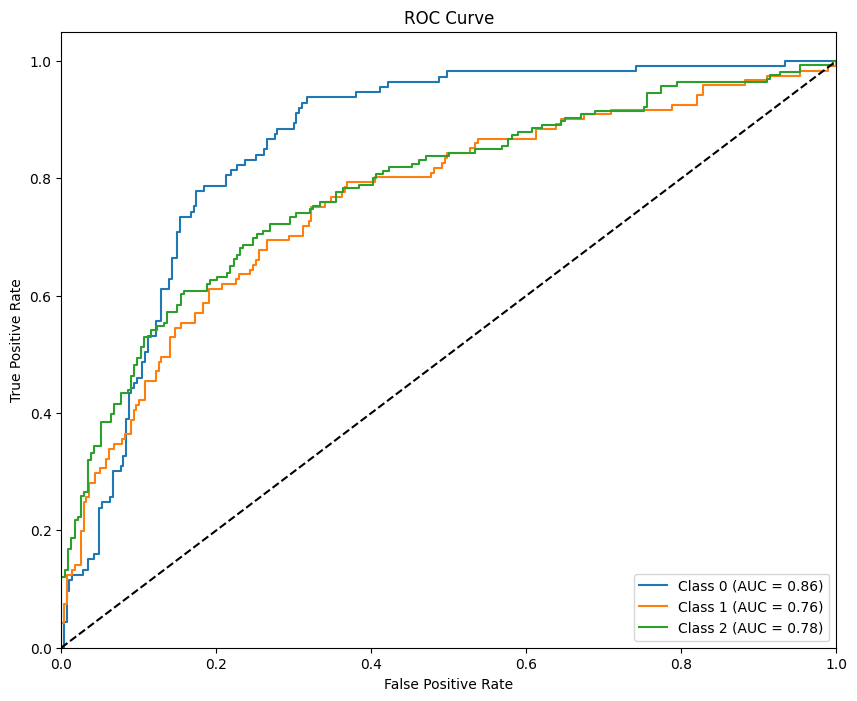

In [21]:
# Prepare data for ROC curve
lb = LabelBinarizer()
lb.fit([0, 1, 2])  # Assuming you have three classes: 0 (positive), 1 (negative), 2 (neutral)
test_labels_bin = lb.transform(true_labels)  # Binarize the true labels
pred_probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions, dtype=torch.float32), dim=-1).numpy()

# Plot ROC curve
def plot_roc_curve(y_true, y_score, label_binarizer):
    plt.figure(figsize=(10, 8))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {label_binarizer.classes_[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels_bin, pred_probs, lb)


The roc curve suggests that the model is able to distingush between the three classes